In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()

In [3]:
factory = nsx.DataReaderFactory()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202.hdf", biodiff)

In [4]:
data = nsx.DataSet(reader, biodiff)

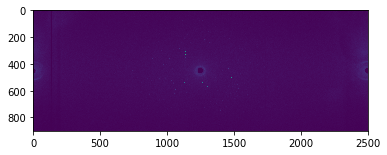

In [5]:
plt.imshow(data.getFrame(0))
plt.show()

In [6]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setConfidence(0.98)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)


In [8]:
numors = nsx.vector_data()
numors.push_back(data)
finder.find(numors)

True

In [9]:
peaks = data.getPeaks()
print(peaks.size())

8925


In [10]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intentisy =", I)
print("std intensity     =", std)

average intentisy = 217474.78258929038
std intensity     = 200586.49100006933
